<a href="https://colab.research.google.com/github/fjadidi2001/Machine_Learning_Journey/blob/main/BuildingDecisionTreeAlgorithmsinPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Creating a decision tree manually (without libraries like scikit-learn) requires implementing the following steps:



# step 1: Calculate Entropy:

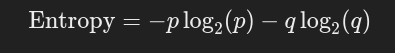

# step 2: Calculate Information Gain:

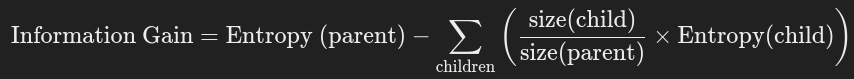

# step 3: Recursive Splitting:

> Starting from the root node, select the best feature, split the data, and repeat for each subset until reaching a stopping criterion, like zero entropy or a maximum depth.


## Without libraries

In [16]:
import math
from collections import Counter
from typing import List, Dict, Union, Tuple, Any
import random

class DecisionTree:
    """
    A Decision Tree classifier implemented from scratch.
    """
    def __init__(self, max_depth: int = 5, min_samples_split: int = 2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.feature_names = None

    def entropy(self, labels: List[str]) -> float:
        """
        Calculate the entropy of a set of labels.

        Args:
            labels: List of class labels
        Returns:
            float: Entropy value
        """
        if not labels:
            return 0.0

        counter = Counter(labels)
        entropy_value = 0.0
        total = len(labels)

        for count in counter.values():
            probability = count / total
            entropy_value -= probability * math.log2(probability)

        return entropy_value

    def split_dataset(self, dataset: List[List], feature_index: int, value: Any) -> Tuple[List[List], List[List]]:
        """
        Split dataset based on a feature value.

        Args:
            dataset: The dataset to split
            feature_index: Index of the feature to split on
            value: Value of the feature to split on
        Returns:
            Tuple of left and right splits
        """
        left_split = [row for row in dataset if row[feature_index] == value]
        right_split = [row for row in dataset if row[feature_index] != value]
        return left_split, right_split

    def information_gain(self, parent: List[List], left_child: List[List], right_child: List[List]) -> float:
        """
        Calculate information gain from a split.

        Args:
            parent: Parent dataset
            left_child: Left split dataset
            right_child: Right split dataset
        Returns:
            float: Information gain value
        """
        if not parent or not left_child or not right_child:
            return 0.0

        total_samples = len(parent)
        parent_entropy = self.entropy([row[-1] for row in parent])
        left_entropy = self.entropy([row[-1] for row in left_child])
        right_entropy = self.entropy([row[-1] for row in right_child])

        left_weight = len(left_child) / total_samples
        right_weight = len(right_child) / total_samples

        weighted_entropy = (left_weight * left_entropy) + (right_weight * right_entropy)
        information_gain = parent_entropy - weighted_entropy

        return information_gain

    def find_best_split(self, dataset: List[List]) -> Tuple[Union[Tuple[int, Any], None], Union[Tuple[List[List], List[List]], None]]:
        """
        Find the best split for the dataset.

        Args:
            dataset: Dataset to find split for
        Returns:
            Tuple of best feature and resulting splits
        """
        best_gain = 0.0
        best_feature = None
        best_splits = None
        n_features = len(dataset[0]) - 1

        for feature_index in range(n_features):
            unique_values = set(row[feature_index] for row in dataset)

            for value in unique_values:
                left_split, right_split = self.split_dataset(dataset, feature_index, value)

                if len(left_split) < self.min_samples_split or len(right_split) < self.min_samples_split:
                    continue

                gain = self.information_gain(dataset, left_split, right_split)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = (feature_index, value)
                    best_splits = (left_split, right_split)

        return best_feature, best_splits

    def build_tree(self, dataset: List[List], depth: int = 0) -> Union[Dict, str]:
        """
        Recursively build the decision tree.

        Args:
            dataset: Dataset to build tree from
            depth: Current depth in the tree
        Returns:
            Dict representing the tree or str for leaf nodes
        """
        labels = [row[-1] for row in dataset]

        # Base cases
        if depth >= self.max_depth or len(dataset) < self.min_samples_split or len(set(labels)) == 1:
            return Counter(labels).most_common(1)[0][0]

        feature, splits = self.find_best_split(dataset)
        if feature is None:
            return Counter(labels).most_common(1)[0][0]

        feature_name = self.feature_names[feature[0]] if self.feature_names else f"Feature_{feature[0]}"
        node = {f"{feature_name} = {feature[1]}": {}}

        # Build left and right branches
        node[f"{feature_name} = {feature[1]}"]["Yes"] = self.build_tree(splits[0], depth + 1)
        node[f"{feature_name} = {feature[1]}"]["No"] = self.build_tree(splits[1], depth + 1)

        return node

    def fit(self, dataset: List[List], feature_names: List[str] = None):
        """
        Train the decision tree on the dataset.

        Args:
            dataset: Training dataset
            feature_names: Optional list of feature names
        """
        self.feature_names = feature_names
        self.tree = self.build_tree(dataset)
        return self

    def predict_single(self, tree: Union[Dict, str], row: List) -> str:
        """
        Make a prediction for a single sample.

        Args:
            tree: Decision tree
            row: Input sample
        Returns:
            str: Predicted class
        """
        if not isinstance(tree, dict):
            return tree

        for condition, branches in tree.items():
            feature_name = condition.split(" = ")[0]
            value = condition.split("= ")[1]

            if self.feature_names:
                feature_index = self.feature_names.index(feature_name)
            else:
                feature_index = int(feature_name.split("_")[1])

            if row[feature_index] == value:
                return self.predict_single(branches["Yes"], row)
            else:
                return self.predict_single(branches["No"], row)

    def predict(self, dataset: List[List]) -> List[str]:
        """
        Make predictions for multiple samples.

        Args:
            dataset: Input dataset
        Returns:
            List[str]: Predicted classes
        """
        return [self.predict_single(self.tree, row) for row in dataset]

    def print_tree(self, tree: Union[Dict, str] = None, depth: int = 0):
        """
        Print a visualization of the tree structure.

        Args:
            tree: Tree to visualize (defaults to self.tree)
            depth: Current depth in the tree
        """
        if tree is None:
            tree = self.tree
            print("Decision Tree Structure:")

        if not isinstance(tree, dict):
            print("  " * depth + f"└── Prediction: {tree}")
            return

        for condition, branches in tree.items():
            print("  " * depth + f"├── {condition}")
            print("  " * (depth + 1) + "├── If Yes:")
            self.print_tree(branches["Yes"], depth + 2)
            print("  " * (depth + 1) + "├── If No:")
            self.print_tree(branches["No"], depth + 2)

# Example usage
if __name__ == "__main__":
    # Sample tennis dataset
    dataset = [
        ['Sunny', 'High', 'Weak', 'No'],
        ['Sunny', 'High', 'Strong', 'No'],
        ['Overcast', 'High', 'Weak', 'Yes'],
        ['Rain', 'High', 'Weak', 'Yes'],
        ['Rain', 'Normal', 'Weak', 'Yes'],
        ['Rain', 'Normal', 'Strong', 'No'],
        ['Overcast', 'Normal', 'Strong', 'Yes'],
        ['Sunny', 'High', 'Weak', 'No'],
        ['Sunny', 'Normal', 'Weak', 'Yes'],
        ['Rain', 'Normal', 'Weak', 'Yes'],
        ['Sunny', 'Normal', 'Strong', 'Yes'],
        ['Overcast', 'High', 'Strong', 'Yes'],
        ['Overcast', 'Normal', 'Weak', 'Yes'],
        ['Rain', 'High', 'Strong', 'No']
    ]

    # Feature names
    feature_names = ['Outlook', 'Humidity', 'Wind']

    # Create and train the decision tree
    dt = DecisionTree(max_depth=3, min_samples_split=2)
    dt.fit(dataset, feature_names)

    # Print the tree structure
    dt.print_tree()

    # Test data
    test_data = [
        ['Sunny', 'High', 'Weak', 'No'],
        ['Rain', 'Normal', 'Strong', 'No'],
        ['Overcast', 'Normal', 'Strong', 'Yes']
    ]

    # Make predictions
    predictions = dt.predict(test_data)

    # Print results
    print("\nPredictions:")
    print("-" * 60)
    print(f"{'Sample':^20} | {'Prediction':^15} | {'Actual':^15}")
    print("-" * 60)

    for i, (pred, actual) in enumerate(zip(predictions, [row[-1] for row in test_data])):
        print(f"Sample {i+1:^13} | {pred:^15} | {actual:^15}")

    # Calculate accuracy
    accuracy = sum(1 for p, a in zip(predictions, [row[-1] for row in test_data]) if p == a) / len(test_data)
    print("-" * 60)
    print(f"\nAccuracy: {accuracy:.2%}")

Decision Tree Structure:
├── Outlook = Overcast
  ├── If Yes:
    └── Prediction: Yes
  ├── If No:
    ├── Humidity = Normal
      ├── If Yes:
        ├── Wind = Strong
          ├── If Yes:
            └── Prediction: No
          ├── If No:
            └── Prediction: Yes
      ├── If No:
        ├── Outlook = Rain
          ├── If Yes:
            └── Prediction: Yes
          ├── If No:
            └── Prediction: No

Predictions:
------------------------------------------------------------
       Sample        |   Prediction    |     Actual     
------------------------------------------------------------
Sample       1       |       No        |       No       
Sample       2       |       No        |       No       
Sample       3       |       Yes       |       Yes      
------------------------------------------------------------

Accuracy: 100.00%


In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

class DecisionTreeEvaluator:
    """
    A class to evaluate Decision Tree performance on new data
    """
    def __init__(self, model):
        self.model = model

    def evaluate_new_data(self, new_data):
        """
        Evaluate model performance on new data with detailed metrics
        """
        predictions = self.model.predict([row[:-1] for row in new_data])
        actual = [row[-1] for row in new_data]

        # Calculate accuracy
        accuracy = sum(1 for p, a in zip(predictions, actual) if p == a) / len(actual)

        # Create confusion matrix
        labels = list(set(actual))
        conf_matrix = confusion_matrix(actual, predictions, labels=labels)

        # Print detailed results
        print("\nDetailed Evaluation on New Data:")
        print("=" * 60)

        print("\nPrediction Results:")
        print("-" * 60)
        print(f"{'Sample':^8} | {'Prediction':^12} | {'Actual':^12} | {'Correct':^8}")
        print("-" * 60)

        for i, (pred, act) in enumerate(zip(predictions, actual), 1):
            correct = "✓" if pred == act else "✗"
            print(f"{i:^8} | {pred:^12} | {act:^12} | {correct:^8}")

        print("\nConfusion Matrix:")
        print("-" * 60)
        print(f"{'':^12} | {'Predicted':^24}")
        print(f"{'Actual':^12} | {'No':^12} | {'Yes':^12}")
        print("-" * 60)

        for i, label in enumerate(labels):
            row = conf_matrix[i]
            print(f"{label:^12} | {row[0]:^12} | {row[1]:^12}")

        # Calculate detailed metrics
        tp = conf_matrix[1][1]  # True Positives
        tn = conf_matrix[0][0]  # True Negatives
        fp = conf_matrix[0][1]  # False Positives
        fn = conf_matrix[1][0]  # False Negatives

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print("\nPerformance Metrics:")
        print("-" * 60)
        print(f"Accuracy:  {accuracy:.2%}")
        print(f"Precision: {precision:.2%}")
        print(f"Recall:    {recall:.2%}")
        print(f"F1 Score:  {f1_score:.2%}")

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'predictions': predictions,
            'confusion_matrix': conf_matrix
        }

# Example usage
if __name__ == "__main__":
    # First, create and train the decision tree as before
    dt = DecisionTree(max_depth=3, min_samples_split=2)

    # Training data
    training_data = [
        ['Sunny', 'High', 'Weak', 'No'],
        ['Sunny', 'High', 'Strong', 'No'],
        ['Overcast', 'High', 'Weak', 'Yes'],
        ['Rain', 'High', 'Weak', 'Yes'],
        ['Rain', 'Normal', 'Weak', 'Yes'],
        ['Rain', 'Normal', 'Strong', 'No'],
        ['Overcast', 'Normal', 'Strong', 'Yes'],
        ['Sunny', 'High', 'Weak', 'No'],
        ['Sunny', 'Normal', 'Weak', 'Yes'],
        ['Rain', 'Normal', 'Weak', 'Yes'],
        ['Sunny', 'Normal', 'Strong', 'Yes'],
        ['Overcast', 'High', 'Strong', 'Yes'],
        ['Overcast', 'Normal', 'Weak', 'Yes'],
        ['Rain', 'High', 'Strong', 'No']
    ]

    # Train the model
    dt.fit(training_data, feature_names=['Outlook', 'Humidity', 'Wind'])

    # New, unseen test data
    new_test_data = [
        # Different weather combinations
        ['Sunny', 'Normal', 'Strong', 'Yes'],    # New combination
        ['Rain', 'High', 'Weak', 'Yes'],         # Seen before
        ['Overcast', 'Normal', 'Strong', 'Yes'], # Seen before
        ['Sunny', 'High', 'Strong', 'No'],       # Seen before
        ['Rain', 'Normal', 'Strong', 'No'],      # Seen before
        ['Overcast', 'High', 'Weak', 'Yes'],     # Seen before
        ['Sunny', 'Normal', 'Weak', 'Yes'],      # Seen before
        ['Rain', 'High', 'Strong', 'No'],        # Seen before
        # Edge cases
        ['Overcast', 'High', 'Strong', 'Yes'],   # Testing strong wind with overcast
        ['Rain', 'Normal', 'Weak', 'Yes'],       # Testing normal humidity with rain
    ]

    # Create evaluator and run evaluation
    evaluator = DecisionTreeEvaluator(dt)
    results = evaluator.evaluate_new_data(new_test_data)

    # Additional analysis of specific cases
    print("\nDetailed Analysis of Interesting Cases:")
    print("-" * 60)

    interesting_cases = [
        (0, "New combination of features"),
        (8, "Edge case: Overcast with strong wind"),
        (9, "Common case: Rain with normal humidity")
    ]

    for idx, description in interesting_cases:
        pred = results['predictions'][idx]
        actual = new_test_data[idx][-1]
        features = new_test_data[idx][:-1]
        print(f"\nCase: {description}")
        print(f"Features: {', '.join(features)}")
        print(f"Prediction: {pred}")
        print(f"Actual: {actual}")
        print(f"Correct: {'✓' if pred == actual else '✗'}")


Detailed Evaluation on New Data:

Prediction Results:
------------------------------------------------------------
 Sample  |  Prediction  |    Actual    | Correct 
------------------------------------------------------------
   1     |      No      |     Yes      |    ✗    
   2     |     Yes      |     Yes      |    ✓    
   3     |     Yes      |     Yes      |    ✓    
   4     |      No      |      No      |    ✓    
   5     |      No      |      No      |    ✓    
   6     |     Yes      |     Yes      |    ✓    
   7     |     Yes      |     Yes      |    ✓    
   8     |     Yes      |      No      |    ✗    
   9     |     Yes      |     Yes      |    ✓    
   10    |     Yes      |     Yes      |    ✓    

Confusion Matrix:
------------------------------------------------------------
             |        Predicted        
   Actual    |      No      |     Yes     
------------------------------------------------------------
    Yes      |      6       |      1      
     N

## Added libraries

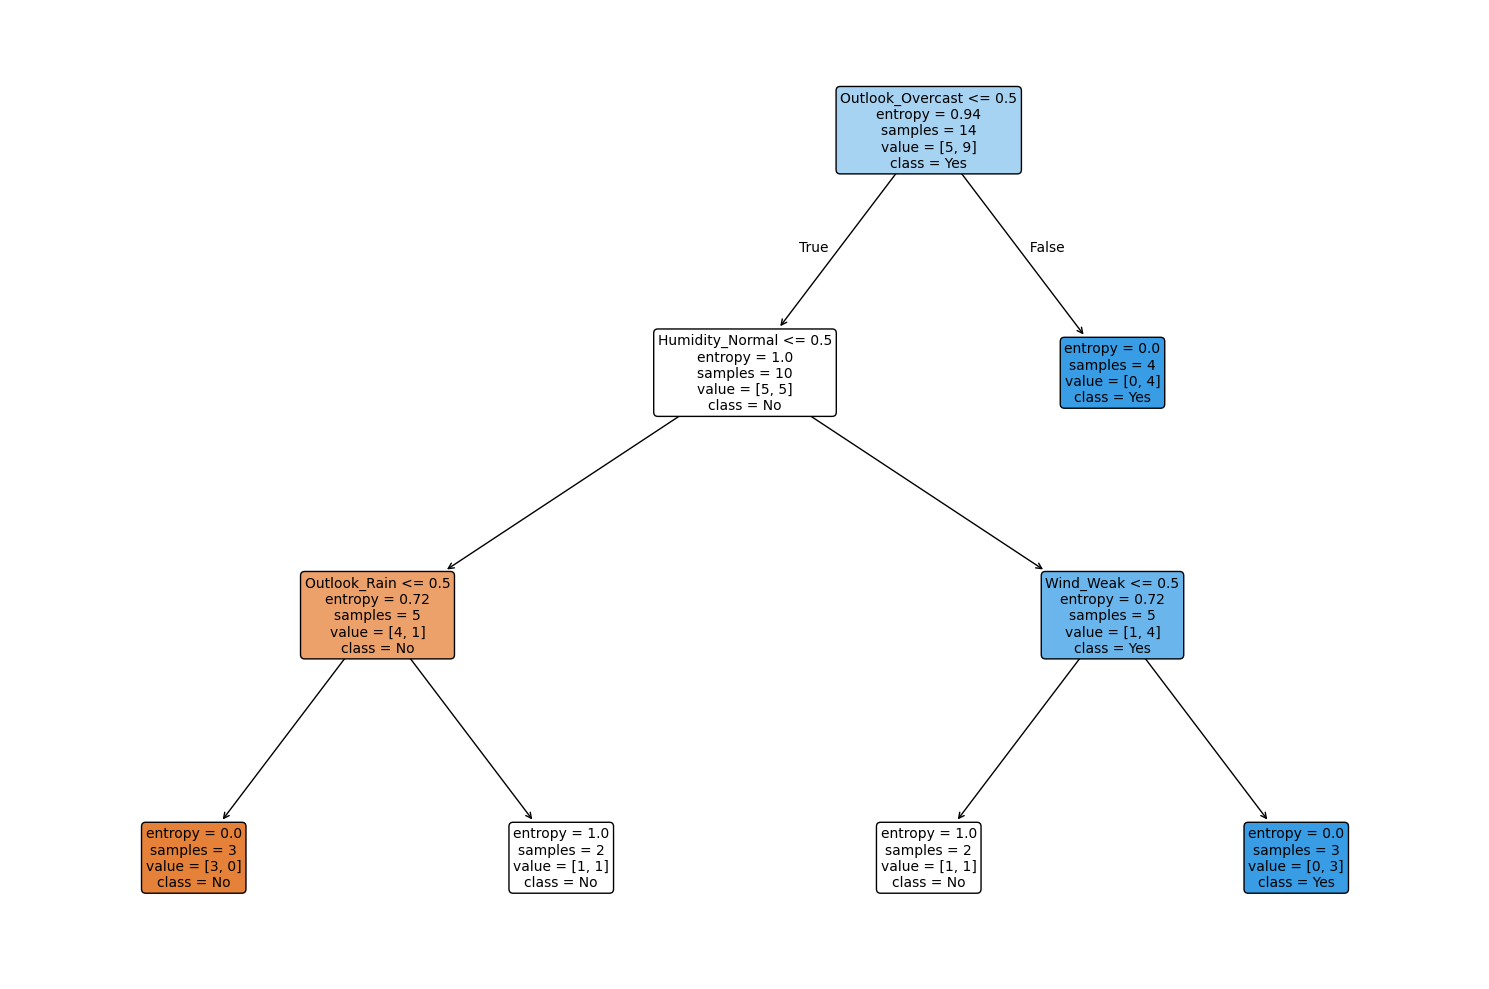


Prediction Results:
--------------------------------------------------
 Sample  |  Predicted   |    Actual    | Correct 
--------------------------------------------------
   1     |      No      |      No      |    ✓    
   2     |     Yes      |     Yes      |    ✓    
   3     |      No      |      No      |    ✓    
   4     |     Yes      |     Yes      |    ✓    
   5     |      No      |      No      |    ✓    
   6     |      No      |     Yes      |    ✗    
   7     |      No      |     Yes      |    ✗    
   8     |     Yes      |     Yes      |    ✓    
   9     |      No      |      No      |    ✓    
--------------------------------------------------

Model Accuracy: 77.78%


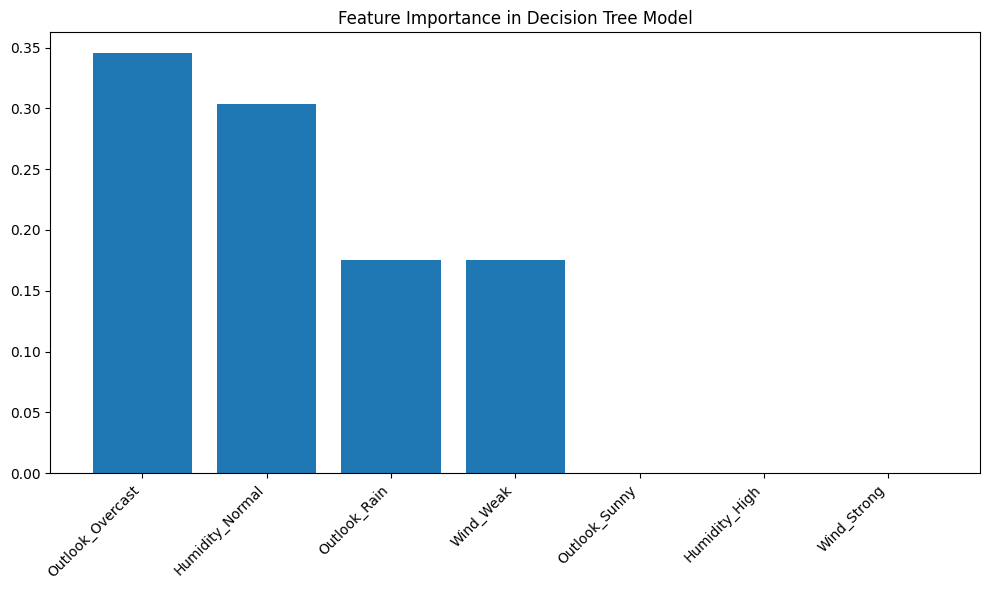

In [15]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define the dataset with clear structure
data = [
    ['Sunny', 'High', 'Weak', 'No'],
    ['Sunny', 'High', 'Strong', 'No'],
    ['Overcast', 'High', 'Weak', 'Yes'],
    ['Rain', 'High', 'Weak', 'Yes'],
    ['Rain', 'Normal', 'Weak', 'Yes'],
    ['Rain', 'Normal', 'Strong', 'No'],
    ['Overcast', 'Normal', 'Strong', 'Yes'],
    ['Sunny', 'High', 'Weak', 'No'],
    ['Sunny', 'Normal', 'Weak', 'Yes'],
    ['Rain', 'Normal', 'Weak', 'Yes'],
    ['Sunny', 'Normal', 'Strong', 'Yes'],
    ['Overcast', 'High', 'Strong', 'Yes'],
    ['Overcast', 'Normal', 'Weak', 'Yes'],
    ['Rain', 'High', 'Strong', 'No']
]

# Create DataFrame with clear column names
columns = ['Outlook', 'Humidity', 'Wind', 'PlayTennis']
df = pd.DataFrame(data, columns=columns)

# Create separate target variable before encoding
y = df['PlayTennis'].map({'Yes': 1, 'No': 0})

# Convert categorical features to numerical values
X = pd.get_dummies(df.drop('PlayTennis', axis=1))

# Create and train the decision tree with better parameters
model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=3,
    random_state=42
)
model.fit(X, y)

# Create a more aesthetically pleasing visualization
plt.figure(figsize=(15, 10))
plt.title('Decision Tree for Playing Tennis', pad=20, size=16)

# Plot the tree with improved styling
plot_tree(
    model,
    feature_names=X.columns,
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True,
    fontsize=10,
    precision=2
)

# Adjust layout to prevent text overlap
plt.tight_layout()

# Save the plot to a file (optional)
plt.savefig('tennis_decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()

# Test data with actual labels
test_data = [
    ['Sunny', 'High', 'Weak', 'No'],
    ['Sunny', 'Normal', 'Weak', 'Yes'],
    ['Rain', 'Normal', 'Strong', 'No'],
    ['Overcast', 'High', 'Weak', 'Yes'],
    ['Sunny', 'High', 'Strong', 'No'],
    ['Rain', 'High', 'Weak', 'Yes'],
    ['Sunny', 'Normal', 'Strong', 'Yes'],
    ['Overcast', 'Normal', 'Strong', 'Yes'],
    ['Rain', 'High', 'Strong', 'No']
]

# Create test DataFrame
test_df = pd.DataFrame(test_data, columns=columns)

# Store actual labels before preprocessing
test_y = test_df['PlayTennis'].map({'Yes': 1, 'No': 0})

# Process test features to match training data structure
test_X = pd.get_dummies(test_df.drop('PlayTennis', axis=1))

# Align test data columns with training data
test_X = test_X.reindex(columns=X.columns, fill_value=0)

# Make predictions
predictions = model.predict(test_X)

# Create a nice prediction results display
print("\nPrediction Results:")
print("-" * 50)
print(f"{'Sample':^8} | {'Predicted':^12} | {'Actual':^12} | {'Correct':^8}")
print("-" * 50)

for i, (pred, actual) in enumerate(zip(predictions, test_y), 1):
    pred_label = 'Yes' if pred == 1 else 'No'
    actual_label = 'Yes' if actual == 1 else 'No'
    correct = '✓' if pred == actual else '✗'
    print(f"{i:^8} | {pred_label:^12} | {actual_label:^12} | {correct:^8}")

print("-" * 50)
accuracy = accuracy_score(test_y, predictions)
print(f"\nModel Accuracy: {accuracy:.2%}")

# Feature importance visualization
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Decision Tree Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()